# **Initializations and Dataset Download**

In [4]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: satishnaiduvulli
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 622MB/s]

# **Import Dependencies**

In [5]:
# import dependencies
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
# check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Dataset**

In [7]:
#converting data into pandas dataframe
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [8]:
#drop missing values
data_df.dropna(inplace=True)

In [9]:
# drop id column
data_df.drop(['id'], axis=1, inplace=True)

In [10]:
print(data_df.shape)

(18185, 11)


In [11]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [12]:
#checking value counts
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


# **Data Preprocessing**

In [13]:
# Normalization
#copy of dataset
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


# **Data Splitting**

In [14]:

X = np.array(data_df.iloc[:, :-1]) #taking all columns except the last one

Y = np.array(data_df.iloc[:, -1]) #only last column

In [15]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [16]:
#splitting test data for cross validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [17]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


# **Dataset Object**

In [18]:
# creating a dataset object
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

# **Training Hyper Parameters**

In [19]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

# **Data Loaders**

In [20]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

# **Model Class**

In [21]:
class MyModel(nn.Module):
  def __init__(self):

    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

# **Model Creation**

In [22]:
model = MyModel().to(device) # assigning model to GPU
summary(model, (X.shape[1],)) # to see how model look like

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# **Loss and Optimizer**

In [23]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = LR)

# **Training the Model**

In [24]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  # Training
  for data in train_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss = criterion(prediction, labels)

    total_loss_train += batch_loss.item()

    acc = ((prediction).round() == labels).sum().item()

    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # Validation
  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)

      batch_loss = criterion(prediction, labels)

      total_loss_val += batch_loss.item()

      acc = ((prediction).round() == labels).sum().item()

      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
  total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()* 100, 4))

  print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f}
        Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
  print("="*50)


Epoch no. 1 Train Loss: 0.2560 Train Accuracy: 71.4117 Validation Loss: 0.0451 Validation Accuracy: 97.0674
Epoch no. 2 Train Loss: 0.1424 Train Accuracy: 97.7767 Validation Loss: 0.0186 Validation Accuracy: 98.5704
Epoch no. 3 Train Loss: 0.0642 Train Accuracy: 98.2402 Validation Loss: 0.0096 Validation Accuracy: 98.6437
Epoch no. 4 Train Loss: 0.0394 Train Accuracy: 98.4131 Validation Loss: 0.0066 Validation Accuracy: 98.7170
Epoch no. 5 Train Loss: 0.0298 Train Accuracy: 98.5309 Validation Loss: 0.0052 Validation Accuracy: 98.7537
Epoch no. 6 Train Loss: 0.0250 Train Accuracy: 98.4759 Validation Loss: 0.0044 Validation Accuracy: 98.7537
Epoch no. 7 Train Loss: 0.0222 Train Accuracy: 98.5702 Validation Loss: 0.0041 Validation Accuracy: 98.8270
Epoch no. 8 Train Loss: 0.0205 Train Accuracy: 98.5545 Validation Loss: 0.0036 Validation Accuracy: 98.8270
Epoch no. 9 Train Loss: 0.0193 Train Accuracy: 98.5388 Validation Loss: 0.0034 Validation Accuracy: 98.8636
Epoch no. 10 Train Loss: 0.0

# **Testing**

In [25]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.72%


# **Plotting and Visualizations**

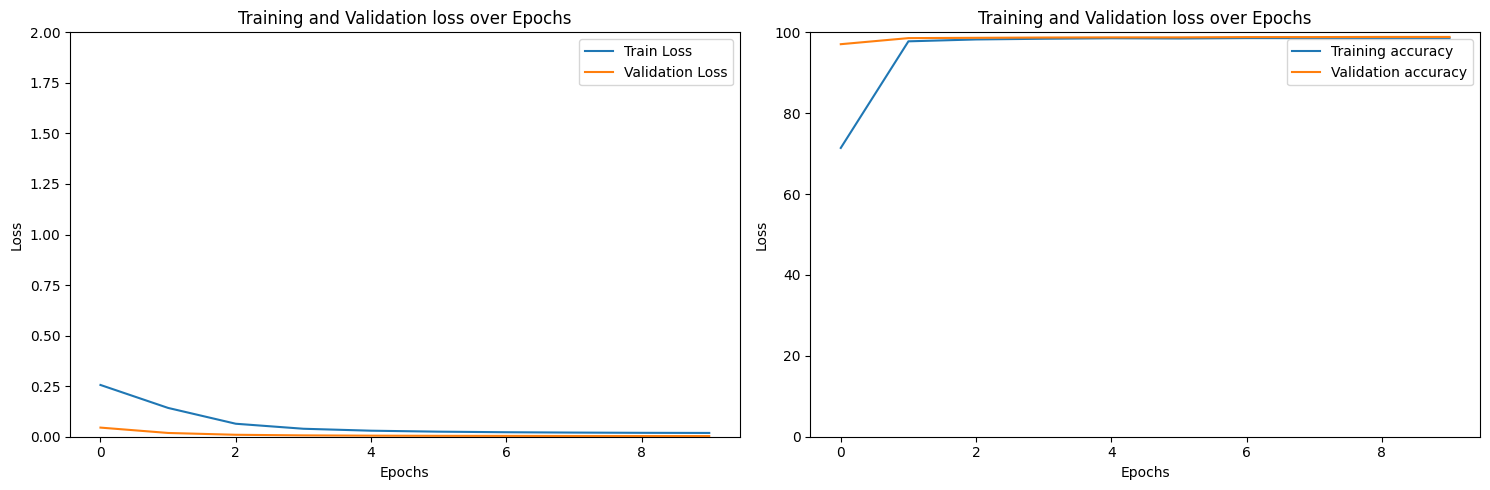

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Train Loss")
axs[0].plot(total_loss_validation_plot, label="Validation Loss")
axs[0].set_title('Training and Validation loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Training accuracy")
axs[1].plot(total_acc_validation_plot, label="Validation accuracy")
axs[1].set_title('Training and Validation loss over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [28]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

Area: 6431.279
Major Axis Length: 145.21338
Minor Axis Length: 56.902
Eccentricity: 0.919981821
Convex Area: 6518.93759999
EquivDiameter: 90.483541
Extent: 0.8506668
Perimeter: 329.972
Roundness: 0.742255516
AspectRation: 2.551696
tensor([0.7824], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  1
